In [1]:
import os
import itertools
from collections import Counter
import warnings
warnings.filterwarnings("ignore", message=".*set_ticklabels.*")


from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import mixup, write_pickled_object, cohen_d
from utils import get_stats as get_stats_best
from utils import FeatureSelector, MeanCenterer

/nobackup/users/hmbaghda/Software/miniforge3/envs/metastatic_potential/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [3]:
res = pd.read_csv(os.path.join(data_path, 'interim', 
                               'pipeline_model_selection_proteomics_individual.csv'), index_col = 0)
model_types = ['Ridge', 'ElasticNet', 'Lasso', 'PLS', 'SVR_linear',
               'SVR_poly', 'SVR_rbf', 'KNN', 'RFR']
res.model_type = pd.Categorical(res.model_type, categories = model_types, ordered = True)

Let's take a look at the results from the model selection:

In [4]:
# sort by mean correlation
ordered_corr = res.groupby('model_type')[['test_corr', 'test_mse']].mean().sort_values(by = 'test_corr', ascending=False)
corr_order = ordered_corr.index.tolist()
ordered_corr


/tmp/ipykernel_4109275/1884020405.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ordered_corr = res.groupby('model_type')[['test_corr', 'test_mse']].mean().sort_values(by = 'test_corr', ascending=False)


,test_corr,test_mse
model_type,,
Ridge,0.368658,2.706870
SVR_rbf,0.346307,2.694200
SVR_poly,0.323762,2.733094
SVR_linear,0.323451,2.686591
PLS,0.299478,2.907243
KNN,0.270529,2.815429
RFR,0.263764,2.809831
Lasso,0.200531,2.997063
ElasticNet,0.189298,2.977427


In [5]:
# sort by correlation variance
res.groupby('model_type').test_corr.var().sort_values(ascending = True)

/tmp/ipykernel_4109275/1169242599.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res.groupby('model_type').test_corr.var().sort_values(ascending = True)


model_type
Ridge         0.011913
SVR_linear    0.014236
SVR_poly      0.017958
KNN           0.025431
Lasso         0.025584
ElasticNet    0.025900
PLS           0.027978
SVR_rbf       0.036439
RFR           0.055760
Name: test_corr, dtype: float64

In [6]:
# sort by mean MSE
ordered_mse = res.groupby('model_type')[['test_corr', 'test_mse']].mean().sort_values(by = 'test_mse', ascending=True)
mse_order = ordered_mse.index.tolist()
ordered_mse

/tmp/ipykernel_4109275/2640724910.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ordered_mse = res.groupby('model_type')[['test_corr', 'test_mse']].mean().sort_values(by = 'test_mse', ascending=True)


,test_corr,test_mse
model_type,,
SVR_linear,0.323451,2.686591
SVR_rbf,0.346307,2.694200
Ridge,0.368658,2.706870
SVR_poly,0.323762,2.733094
RFR,0.263764,2.809831
KNN,0.270529,2.815429
PLS,0.299478,2.907243
ElasticNet,0.189298,2.977427
Lasso,0.200531,2.997063


In [7]:
# sort by mse variance
res.groupby('model_type').test_mse.var().sort_values(ascending = True)

/tmp/ipykernel_4109275/3230113901.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res.groupby('model_type').test_mse.var().sort_values(ascending = True)


model_type
Lasso         0.183699
SVR_rbf       0.205963
ElasticNet    0.215080
Ridge         0.224335
RFR           0.231485
SVR_linear    0.240198
KNN           0.289410
SVR_poly      0.305893
PLS           0.405890
Name: test_mse, dtype: float64

Let's compare each models performance with identified best hyperparameters for a specific fold:

In [8]:
res_stats = pd.DataFrame(columns = ['comparison', 'pval_corr', 'cohen_d_corr', 
                                   'pval_mse', 'cohen_d_mse'])
mod_combs = itertools.combinations((res.model_type.unique()), 2)

for mc in mod_combs:
    a = res[res.model_type == mc[0]]
    b = res[res.model_type == mc[1]]
    
    pval_corr = stats.mannwhitneyu(a.test_corr,b.test_corr).pvalue
    cd_corr = cohen_d(a.test_corr,b.test_corr)
    
    pval_mse = stats.mannwhitneyu(a.test_mse,b.test_mse).pvalue
    cd_mse = cohen_d(a.test_mse,b.test_mse)
    
    res_stats.loc[res_stats.shape[0], :] = [mc, pval_corr, cd_corr, pval_mse, cd_mse]
    
_, fdr_corr, _, _ = multipletests(res_stats.pval_corr.values, method='fdr_bh')
_, fdr_mse, _, _ = multipletests(res_stats.pval_mse.values, method='fdr_bh')
res_stats['fdr_corr'] = fdr_corr
res_stats['fdr_mse'] = fdr_mse
res_stats.to_csv(os.path.join(data_path, 'processed', 'proteomics_comparison_stats.csv'))
res_stats

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
0,"(SVR_linear, PLS)",0.57075,0.165008,0.57075,-0.388219,0.79027,0.933955
1,"(SVR_linear, Ridge)",0.427355,-0.395355,0.909722,-0.042078,0.79027,0.99756
2,"(SVR_linear, Lasso)",0.075662,0.871136,0.212294,-0.674385,0.400379,0.933955
3,"(SVR_linear, ElasticNet)",0.037635,0.946995,0.161972,-0.609573,0.400379,0.933955
4,"(SVR_linear, SVR_poly)",0.73373,-0.002453,0.909722,-0.088996,0.880476,0.99756
5,"(SVR_linear, SVR_rbf)",0.57075,-0.143587,0.96985,-0.016111,0.79027,0.99756
6,"(SVR_linear, RFR)",0.909722,0.31905,0.623176,-0.25377,1.0,0.934764
7,"(SVR_linear, KNN)",0.427355,0.375786,0.344704,-0.250371,0.79027,0.933955
8,"(PLS, Ridge)",0.273036,-0.489836,0.57075,0.356949,0.756101,0.933955
9,"(PLS, Lasso)",0.273036,0.604625,0.344704,-0.165431,0.756101,0.933955


In [9]:
res_stats[res_stats.fdr_corr <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse


In [10]:
res_stats[res_stats.fdr_mse <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse


Just as in the transcriptomics dataset, there are no significant differences in model performance by either Pearson correlation or MSE.

/tmp/ipykernel_3715769/4033864872.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i],
/tmp/ipykernel_3715769/4033864872.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i],


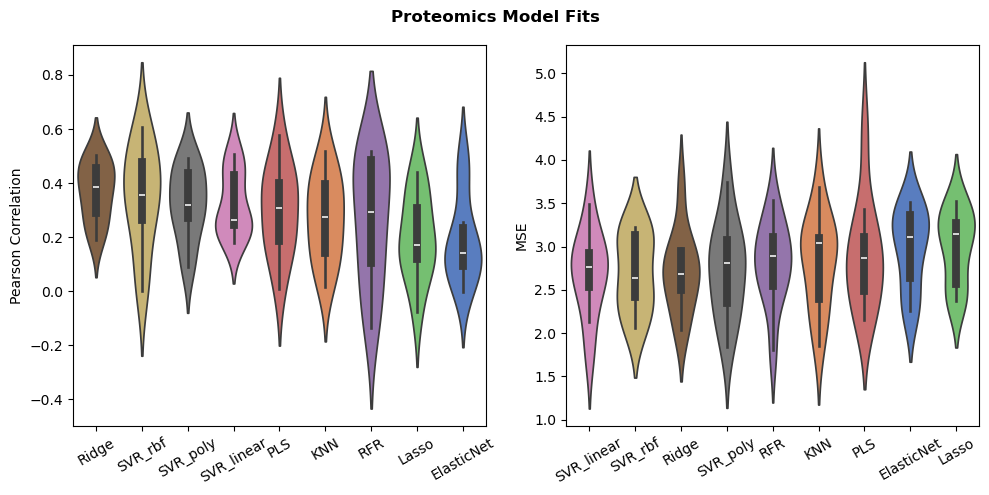

In [18]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))
order_map = dict(zip(metric_types, [corr_order, mse_order]))

palette = dict(zip(sorted(res.model_type.unique()), sns.color_palette("muted")))

for i, metric_type in enumerate(metric_types):
    # sort by mean of metric
    res.model_type = pd.Categorical(res.model_type, categories = order_map[metric_type], 
                               ordered = True)
    
    
    sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i], 
                  palette = palette)#,
#                    fill = False, inner = None)
    
#     sns.boxplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                 width=0.1, 
#                 color="black", showcaps=False, boxprops={'facecolor':'none'}, 
#                 whiskerprops={'linewidth':0.5}, ax = ax[i])
#     sns.stripplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                   alpha=0.5, jitter=True, dodge=True, ax = ax[i], color = 'black')
    
    ax[i].set_xlabel('')
    ax[i].set_ylabel(mmap[metric_type])
    
    xlabels = [x._text for x in ax[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, ax[i].get_xticks()))
    y, h = ax[i].get_ylim()[1], 0.05
    
    ax[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr_' + metric_type].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d_' + metric_type].values[0]
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
            y_pos = y+(sig_counter*0.15)
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=1.01
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1

#     ax[i].grid(axis='y', linestyle='--', alpha=0.7)

# fig.suptitle('Proteomics Model Fits')
fig.suptitle('Proteomics Model Fits',
    fontweight='bold',  # Makes the text bold
)


fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'all_models_proteomics.png'), 
            dpi=300, 
            bbox_inches="tight")  

For each metric (panels), violin plots are ordered by the best performing mean value across folds. Each fold has the best model selected using optuna hyperparameter tuning. We observe the following: 
- there are no significant differences in any of the model performance for both correlation and MSE
- relative model performance is consistent between correlation and MSE, with SVMs performing best (with the exception of Ridge regression).

# Consensus model

Here, we simply want to assess consensus proteomics models' predictive performance, particularly relative to transcriptomics. Thus, we'll take the top two models by each metric, and see how they perform as compared to the consensus model identified for transcriptomics (in [this notebook]( ../A_rna_prediction/03_predict_transcriptomics.ipynb)). Between Pearson correlation and MSE, the top 3 performing models are:
- Ridge
- SVR poly
- SVR linear
- SVR rbf

In [4]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_protein.csv'), index_col = 0)['mean'].values.ravel()
X.shape


(248, 10969)

Let's get the consensus model for ridge:

In [5]:
model_type = 'Ridge'
print(model_type)
res_model = res[res.model_type == model_type]

features_best = []
alpha_best = []
for bp in res_model.best_params:
    print(bp)
    print('------------------------------------------------------')
    features_best.append(int(bp.split(', ')[0].split(': ')[1]))
    alpha_best.append(float(bp.split(', ')[1].split(': ')[1][:-1]))
    
    
best_steps = [
    ("feature_reduction", FeatureSelector(n_features = Counter(features_best).most_common()[0][0])),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", Ridge(
    alpha  = np.mean(alpha_best),
    random_state=random_state,
#     n_jobs=n_cores
)))
best_pipeline_ridge = Pipeline(best_steps)
best_pipeline_ridge

Ridge
{'FeatureSelector__n_features': 10969, 'Ridge__alpha': 88.57067420651218}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'Ridge__alpha': 95.69706126252765}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'Ridge__alpha': 92.95580878994784}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'Ridge__alpha': 96.55445068563309}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'Ridge__alpha': 99.84183202909519}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'Ridge__alpha': 75.68438238635979}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'Ridge__alpha': 96.83342492607719}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'Ridge__alpha': 98.69936049899013}
-----------------

Pipeline(steps=[('feature_reduction', FeatureSelector(n_features=10969)),
                ('mean_centering', MeanCenterer()),
                ('model',
                 Ridge(alpha=np.float64(91.3309019562989), random_state=42))])

In [6]:
model_type = 'SVR_linear'
print(model_type)

res_model = res[res.model_type == model_type]

features_best = []
C_best = []
epsilon_best = []
for bp in res_model.best_params:
    print(bp)
    print('------------------------------------------------------')
    features_best.append(int(bp.split(', ')[0].split(': ')[1]))
    C_best.append(float(bp.split(', ')[1].split(': ')[1]))
    epsilon_best.append(float(bp.split(', ')[2].split(': ')[1][:-1]))
    
    
best_steps = [
    ("feature_reduction", FeatureSelector(n_features = 1000)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=np.mean(C_best),
    epsilon=np.mean(epsilon_best)
)))
best_pipeline_svr_linear = Pipeline(best_steps)

write_pickled_object(best_pipeline_svr_linear, 
                    os.path.join(data_path, 'processed', 'best_model_proteomics_svrlinear.pickle'))

best_pipeline_svr_linear

SVR_linear
{'FeatureSelector__n_features': 10969, 'SVR_linear__C': 0.2759058964392929, 'SVR_linear__epsilon': 0.6700914410921143}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'SVR_linear__C': 0.017554335753692214, 'SVR_linear__epsilon': 0.5791800861642572}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'SVR_linear__C': 0.0015863016106384207, 'SVR_linear__epsilon': 1.3423906638729315}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'SVR_linear__C': 0.01333287761002319, 'SVR_linear__epsilon': 0.32243794696089956}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'SVR_linear__C': 0.0002642883616590924, 'SVR_linear__epsilon': 0.3212520157811789}
------------------------------------------------------
{'FeatureSelector__n_features': 1000, 'SVR_linear__C': 0.002914181707556481, 'SVR_linear__epsilon': 1.3017832

Pipeline(steps=[('feature_reduction', FeatureSelector(n_features=1000)),
                ('mean_centering', MeanCenterer()),
                ('model',
                 SVR(C=np.float64(1.11827807213645),
                     epsilon=np.float64(0.8356283538003003),
                     kernel='linear'))])

In the linear SVR mdoel, since the number of features selected is split evenly between 1000 and all features (10968), we choose the one with fewer features as it results in a simpler model. 

In [7]:
model_type = 'SVR_rbf'
print(model_type)

res_model = res[res.model_type == model_type]

features_best = []
C_best = []
epsilon_best = []
gamma_best = []
for bp in res_model.best_params:
    print(bp)
    print('------------------------------------------------------')
    features_best.append(int(bp.split(', ')[0].split(': ')[1]))
    C_best.append(float(bp.split(', ')[1].split(': ')[1]))
    epsilon_best.append(float(bp.split(', ')[2].split(': ')[1]))
    gamma_best.append((bp.split(', ')[3].split(': ')[1][:-1]))
gamma_best = [eval(i) for i in gamma_best]
    
    
best_steps = [
    ("feature_reduction", FeatureSelector(n_features = Counter(features_best).most_common()[0][0])),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='rbf',
    C=np.mean(C_best),
    epsilon=np.mean(epsilon_best),
    gamma = Counter(gamma_best).most_common()[0][0]
)))
best_pipeline_rbf = Pipeline(best_steps)
best_pipeline_rbf

SVR_rbf
{'FeatureSelector__n_features': 1000, 'SVR_rbf__C': 1.5334667933323716, 'SVR_rbf__epsilon': 0.1333988981836593, 'SVR_rbf__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features': 1000, 'SVR_rbf__C': 4.682857758787835, 'SVR_rbf__epsilon': 0.09355875531605841, 'SVR_rbf__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'SVR_rbf__C': 6.580364047675523, 'SVR_rbf__epsilon': 0.001647525373838901, 'SVR_rbf__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features': 5000, 'SVR_rbf__C': 90.75505550097586, 'SVR_rbf__epsilon': 0.12315053050515708, 'SVR_rbf__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features': 1000, 'SVR_rbf__C': 22.263267686704854, 'SVR_rbf__epsilon': 0.7755624546014125, 'SVR_rbf__gamma': 'scale'}
------------------------------------------------------
{'FeatureSelector__n_fea

Pipeline(steps=[('feature_reduction', FeatureSelector(n_features=1000)),
                ('mean_centering', MeanCenterer()),
                ('model',
                 SVR(C=np.float64(20.55595632343639),
                     epsilon=np.float64(0.24686733364107943), gamma='auto'))])

In [8]:
model_type = 'SVR_poly'
print(model_type)

res_model = res[res.model_type == model_type]

features_best = []
C_best = []
epsilon_best = []
degree_best = []
gamma_best = []
coef0_best = []
gamma_best = []
for bp in res_model.best_params:
    print(bp)
    print('------------------------------------------------------')
    features_best.append(int(bp.split(', ')[0].split(': ')[1]))
    C_best.append(float(bp.split(', ')[1].split(': ')[1]))
    epsilon_best.append(float(bp.split(', ')[2].split(': ')[1]))
    degree_best.append(int(bp.split(', ')[3].split(': ')[1]))
    coef0_best.append(float(bp.split(', ')[4].split(': ')[1]))
    gamma_best.append((bp.split(', ')[5].split(': ')[1][:-1]))
gamma_best = [eval(i) for i in gamma_best]

    
best_steps = [
    ("feature_reduction", FeatureSelector(n_features = Counter(features_best).most_common()[0][0])),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='poly',
    C=np.mean(C_best),
    epsilon=np.mean(epsilon_best),
    gamma = Counter(gamma_best).most_common()[0][0], 
    degree = Counter(degree_best).most_common()[0][0], 
    coef0 = np.mean(coef0_best)
#     random_state=random_state,
#     n_jobs=n_cores
)))
best_pipeline_poly = Pipeline(best_steps)
best_pipeline_poly

SVR_poly
{'FeatureSelector__n_features': 10969, 'SVR_poly__C': 3.2648882873676772, 'SVR_poly__epsilon': 0.12615106502618043, 'SVR_poly__degree': 4, 'SVR_poly__coef0': 1.5, 'SVR_poly__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features': 5000, 'SVR_poly__C': 15.582339277746184, 'SVR_poly__epsilon': 0.09818434302625324, 'SVR_poly__degree': 3, 'SVR_poly__coef0': 1.1, 'SVR_poly__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'SVR_poly__C': 3.0451128727264183, 'SVR_poly__epsilon': 0.00970936786668425, 'SVR_poly__degree': 4, 'SVR_poly__coef0': 1.5, 'SVR_poly__gamma': 'scale'}
------------------------------------------------------
{'FeatureSelector__n_features': 10969, 'SVR_poly__C': 3.3171745542529254, 'SVR_poly__epsilon': 0.005789055311857516, 'SVR_poly__degree': 5, 'SVR_poly__coef0': 2.0, 'SVR_poly__gamma': 'auto'}
------------------------------------------------------
{'FeatureS

Pipeline(steps=[('feature_reduction', FeatureSelector(n_features=10969)),
                ('mean_centering', MeanCenterer()),
                ('model',
                 SVR(C=np.float64(14.142903595168026), coef0=np.float64(1.45),
                     degree=4, epsilon=np.float64(0.2997766955846183),
                     gamma='auto', kernel='poly'))])

In [9]:
best_pipelines = {'ridge': best_pipeline_ridge, 
                 'svr_linear': best_pipeline_svr_linear, 
                 'svr_poly': best_pipeline_poly, 
                 'svr_rbf': best_pipeline_rbf}

In [5]:
# np.random.seed(random_state)
# outer_cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
# n_synthetic = 1000
# augment = False
# # res = {}

# # baseline_svr_linear = LinearRegression(n_jobs = n_cores)

# results = []
# for k, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y))):
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
    
#     # augment data
#     if augment:
#         synthetic_X, synthetic_y = mixup(X_train, y_train, n_synthetic = n_synthetic, alpha = 2, 
#                                          random_state = random_state)
#         X_train = np.concatenate((X_train, synthetic_X), axis = 0)
#         y_train = np.concatenate((y_train, synthetic_y), axis = 0)
        
#     results_dict = {'fold': k}
    
#     for mod_type, best_pipeline in best_pipelines.items():
#         train_corr, test_corr, train_mse, test_mse = get_stats_best(best_pipeline, y_train, y_test, X_train, X_test)
        
#         # random y
#         y_train_rand = np.random.permutation(y_train)
#         res_y_rand = get_stats_best(best_pipeline, y_train_rand, y_test, X_train, X_test)
#         _, test_corr_y_rand, _, test_mse_y_rand = res_y_rand   
        
#         # random X
#         X_train_rand = X_train[:, np.random.permutation(X_train.shape[1])]
#         res_X_rand = get_stats_best(best_pipeline, y_train, y_test, X_train_rand, X_test)
#         _, test_corr_X_rand, _, test_mse_X_rand = res_X_rand 
        
#         mod_dict = {
#             "train_corr_" + mod_type: train_corr,
#             "test_corr_" + mod_type: test_corr,
#             'train_mse_' + mod_type: train_mse, 
#             'test_mse_' + mod_type: test_mse,
            
#             "random_y_test_corr_" + mod_type: test_corr_y_rand,
#             'random_y_test_mse_' + mod_type: test_mse_y_rand,
            
#             "random_X_test_corr_" + mod_type: test_corr_X_rand,
#             'random_X_test_mse_' + mod_type: test_mse_X_rand,
            
            
#         }
#         results_dict = {**results_dict, **mod_dict}

#     results.append(results_dict)
#     best_res_df = pd.DataFrame(results)
# best_res_df.to_csv(os.path.join(data_path, 'processed', 'proteomics_consensus_performance.csv'))
best_res_df = pd.read_csv(os.path.join(data_path, 'processed', 'proteomics_consensus_performance.csv'), 
                         index_col = 0)

In [11]:
test_res = best_res_df[[col for col in best_res_df if 'test' in col and 'random' not in col]]
test_res[[col for col in test_res if 'corr' in col]].mean(axis = 0).sort_values(ascending = False)


test_corr_ridge         0.389756
test_corr_svr_poly      0.387359
test_corr_svr_rbf       0.355895
test_corr_svr_linear    0.293441
dtype: float64

In [12]:
test_res[[col for col in test_res if 'corr' in col]].std(axis = 0).sort_values(ascending = True)


test_corr_svr_rbf       0.183122
test_corr_ridge         0.196950
test_corr_svr_poly      0.202804
test_corr_svr_linear    0.246630
dtype: float64

In [21]:
test_res[[col for col in test_res if 'mse' in col]].mean(axis = 0).sort_values(ascending = True)


test_mse_svr_poly      2.588515
test_mse_svr_rbf       2.628803
test_mse_ridge         2.672523
test_mse_svr_linear    2.950566
dtype: float64

In [22]:
test_res[[col for col in test_res if 'mse' in col]].std(axis = 0).sort_values(ascending = True)


test_mse_svr_rbf       0.660904
test_mse_svr_poly      0.672631
test_mse_ridge         0.758167
test_mse_svr_linear    0.938211
dtype: float64

In [28]:
for model_type in best_pipelines.keys():
    print('The mean Pearson correlation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].mean()))
    print('The median Pearson correlation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].median()))
    print('The std Pearson correlation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].std()))
    
    print('The mean MSE for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].mean()))
    print('The median MSE for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].median()))
    print('The std MSE for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].std()))

    print('----------')

The mean Pearson correlation for ridge is 0.389756
The median Pearson correlation for ridge is 0.395677
The std Pearson correlation for ridge is 0.196950
The mean MSE for ridge is 2.672523
The median MSE for ridge is 2.825153
The std MSE for ridge is 0.758167
----------
The mean Pearson correlation for svr_linear is 0.293441
The median Pearson correlation for svr_linear is 0.293074
The std Pearson correlation for svr_linear is 0.246630
The mean MSE for svr_linear is 2.950566
The median MSE for svr_linear is 2.774206
The std MSE for svr_linear is 0.938211
----------
The mean Pearson correlation for svr_poly is 0.387359
The median Pearson correlation for svr_poly is 0.353649
The std Pearson correlation for svr_poly is 0.202804
The mean MSE for svr_poly is 2.588515
The median MSE for svr_poly is 2.594012
The std MSE for svr_poly is 0.672631
----------
The mean Pearson correlation for svr_rbf is 0.355895
The median Pearson correlation for svr_rbf is 0.363599
The std Pearson correlation for

### Assessment 1

First, let's test whether each consensus model performs better than random:

In [7]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
# split by metric type
viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]

viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}
mmap = dict(zip(viz_dfs.keys(), ['corr', 'mse']))
model_map = dict(zip(best_pipelines.keys(), 
                    ['Ridge', 'Linear SVR', 'Polynomial SVR', 'RBF SVR']))

unit_map = {'h': dict(zip(viz_dfs.keys(), [0.05, 0.2])),
            'y_pos_scale_0': dict(zip(viz_dfs.keys(), [0.175, 0.525])),
           'y_pos_scale': dict(zip(viz_dfs.keys(), [1.01, 1.01])), 
           'y_max_scale': dict(zip(viz_dfs.keys(), [1.15, 1.1]))}

In [8]:
viz_df_corr

,test_corr_ridge,random_y_test_corr_ridge,random_X_test_corr_ridge,test_corr_svr_linear,random_y_test_corr_svr_linear,random_X_test_corr_svr_linear,test_corr_svr_poly,random_y_test_corr_svr_poly,random_X_test_corr_svr_poly,test_corr_svr_rbf,random_y_test_corr_svr_rbf,random_X_test_corr_svr_rbf
0,0.710424,-0.032919,0.271131,0.588224,-0.123899,-0.126325,0.742562,-0.156175,0.215856,0.664606,0.139895,0.094589
1,0.256610,-0.216367,0.111034,0.511440,0.115760,0.313489,0.286300,-0.124584,-0.149060,0.488378,0.137996,-0.169927
2,0.345592,0.240100,0.147755,0.283489,-0.200623,-0.161819,0.301045,-0.261190,-0.072295,0.311545,-0.386859,-0.266058
3,0.232575,-0.167032,-0.001024,0.276570,0.136913,0.084276,0.185215,0.222036,-0.035088,0.152886,0.302463,-0.358848
4,0.188076,0.141700,0.207428,0.176329,-0.174450,-0.162760,0.250574,0.051328,-0.127661,0.195666,0.027231,0.121361
5,0.503213,0.028494,-0.203055,0.395573,0.237531,0.313810,0.436349,0.320228,0.231934,0.483425,-0.097708,0.011330
6,0.445762,0.045912,0.028831,0.219392,0.254669,-0.262089,0.406608,-0.114019,0.160226,0.347881,-0.334254,-0.001679
7,0.511959,-0.014746,0.357116,-0.297215,-0.361958,0.036054,0.406253,0.154019,0.287616,0.058296,0.085886,-0.125648
8,0.099311,0.294118,-0.031569,0.477950,-0.110635,-0.308526,0.146408,0.212704,0.176667,0.379317,-0.359216,0.103582
9,0.604038,-0.037693,-0.135328,0.302660,-0.220514,-0.178329,0.712280,0.058867,-0.238632,0.476952,0.180393,0.096265


In [17]:
def get_stats(viz_df, stat_type, model_type, metric_type):
    res_stats = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d'])
    mod_combs = list(itertools.combinations((viz_df['Model Type'].unique()), 2))
    
    if stat_type == 'random':
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Randomly') == 1]
        
        if metric_type == 'Pearson Correlation':
            alternative = 'greater'
        elif metric_type == 'Mean Squared Error':
            alternative = 'less'
        
        # reorder
        shared_element = model_map[model_type]
        mod_combs = [
            (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
            for elem in mod_combs
        ]
    elif stat_type == 'within':
        alternative = 'two-sided'
    elif stat_type == 'transcriptomics':     
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Transcriptomics') == 1]
        alternative = 'two-sided'
        
#         if metric_type == 'Pearson Correlation':
#             alternative = 'greater'
#         elif metric_type == 'Mean Squared Error':
#             alternative = 'less'
        
#         # reorder
#         shared_element = 'Linear SVR - Transcriptomics'
#         mod_combs = [
#             (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
#             for elem in mod_combs
#         ]
        

    for mc in mod_combs:
        a = viz_df[viz_df['Model Type'] == mc[0]].iloc[:, 1]
        b = viz_df[viz_df['Model Type'] == mc[1]].iloc[:, 1]

        pval = stats.mannwhitneyu(a,b, alternative = alternative).pvalue
        cd = cohen_d(a,b)

        res_stats.loc[res_stats.shape[0], :] = [mc, pval, cd]

    _, fdr, _, _ = multipletests(res_stats.pval.values, method='fdr_bh')
    res_stats['fdr'] = fdr
    
    return res_stats, mod_combs

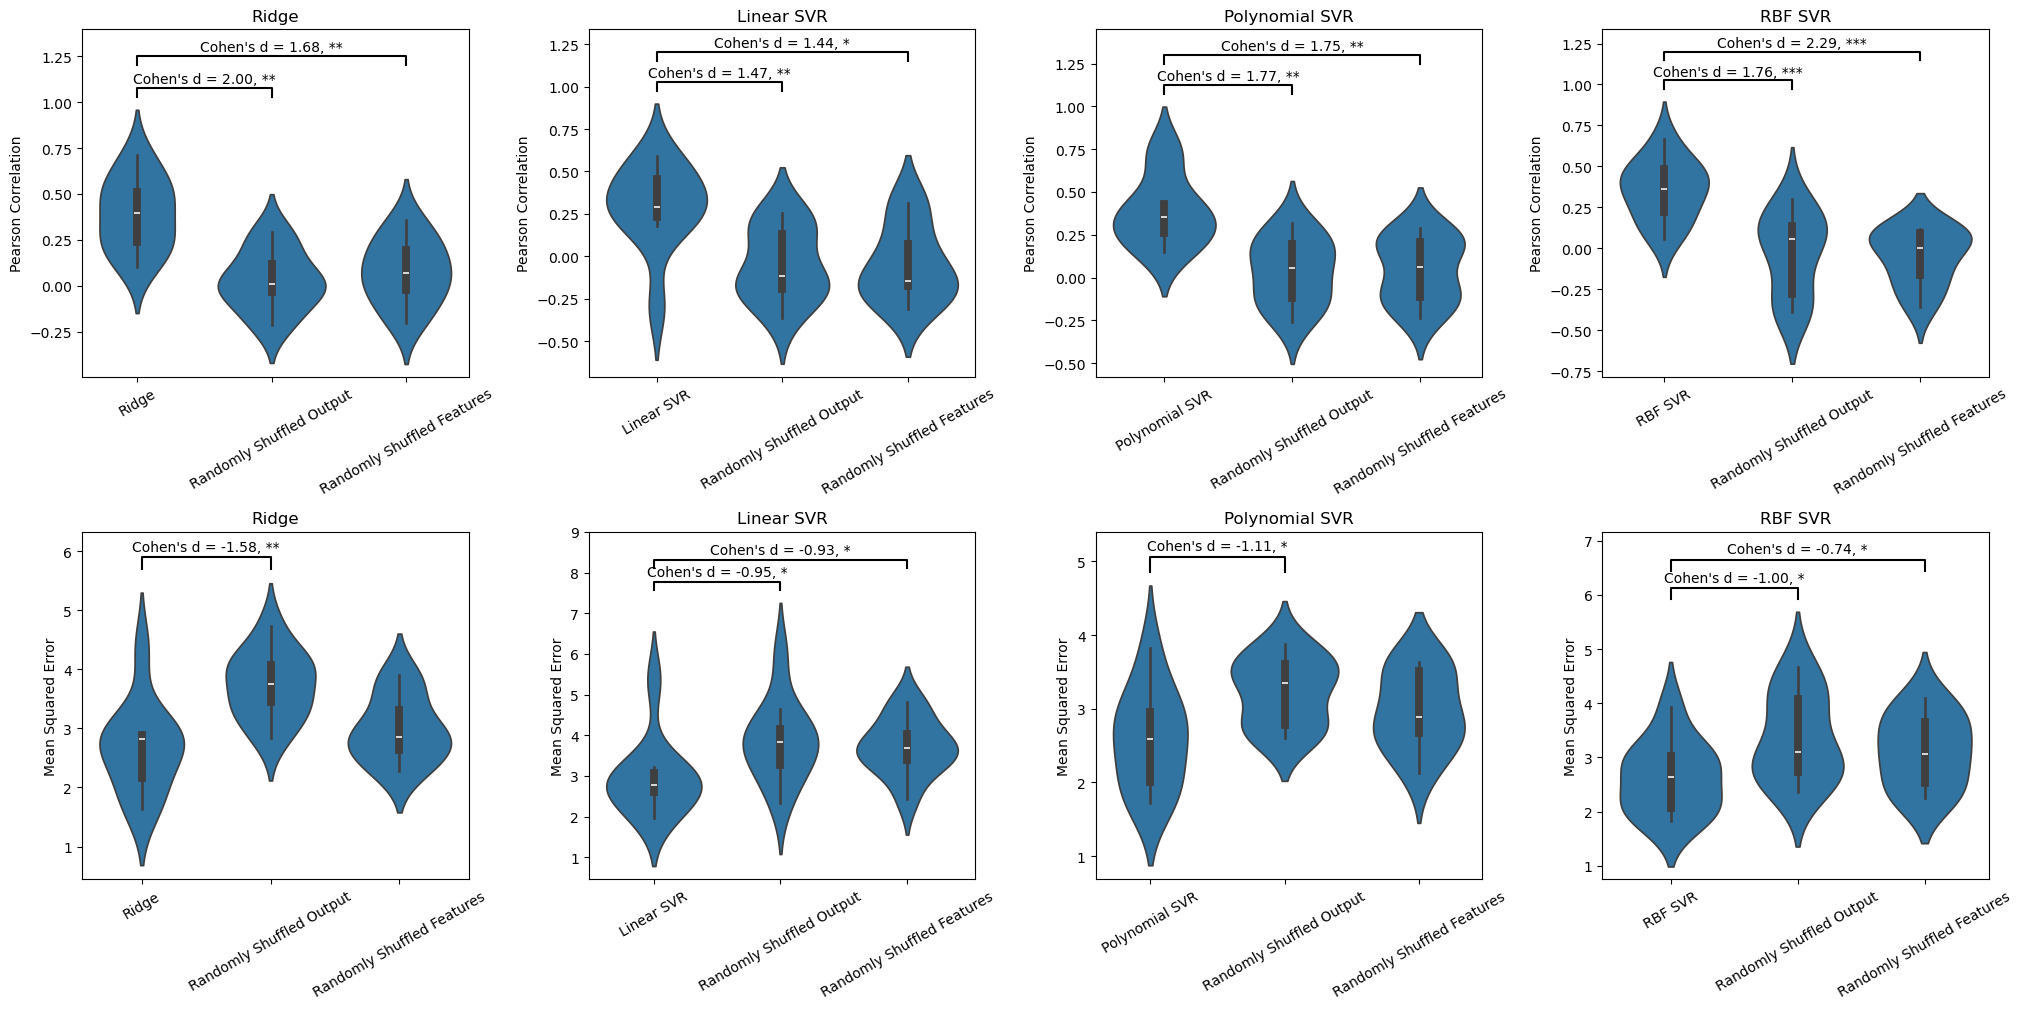

In [26]:
ncols = len(best_pipelines)
nrows = 2 # two metrics
fig, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = (ncols*5.1, nrows*5.1))

for j, model_type in enumerate(best_pipelines.keys()):
#     break
    
    for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
        viz_df = viz_df_[[col for col in viz_df_ if model_type in col]]
        viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

        # some formatting
        viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type], 
                                  'random_y_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Output', 
                                 'random_X_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Features'})
        
        # may want to do this across all comparisons simultaneously
        res_stats, mod_combs = get_stats(viz_df, stat_type = 'random', model_type = model_type, metric_type = metric_type)

        sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i, j])
        ax[i, j].set_title(model_map[model_type])
        ax[i, j].set_xlabel('')
        
        xlabels = [x._text for x in ax[i, j].get_xticklabels()]
        ax[i, j].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
        
        x_pos = dict(zip(xlabels, ax[i,j].get_xticks()))

        y_lower, y = ax[i,j].get_ylim()
        h = unit_map['h'][metric_type]
        
        # significance
        sig_counter = 0
        for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
            x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

            fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
            cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

            significance = "N.S."
            if fdr <= 1e-4:
                significance = "****"
            elif fdr <= 0.001:
                significance = "***"
            elif fdr <= 0.01:
                significance = "**"
            elif fdr <= 0.1:
                significance = "*"

            if significance != 'N.S.':
    #             y_pos = y+(sig_counter*0.15)
                y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
                ax[i,j].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                        [y_pos, y_pos+h, y_pos+h, y_pos], 
                        lw=1.5, c='black')
                y_pos*=unit_map['y_pos_scale'][metric_type]
                ax[i,j].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                        ha='center', va='bottom', fontsize=10)
                sig_counter += 1
        if sig_counter != 0:
            ax[i,j].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'random_proteomics.png'), 
            dpi=300, 
            bbox_inches="tight")  

All models perform better than random for the Pearson Correlation. However, for the MSE, only the Linear and RBF SVR performs better than both random baselines.

### Assessment 2

Next, let's test whether there is a difference in model performance across the consensus models:

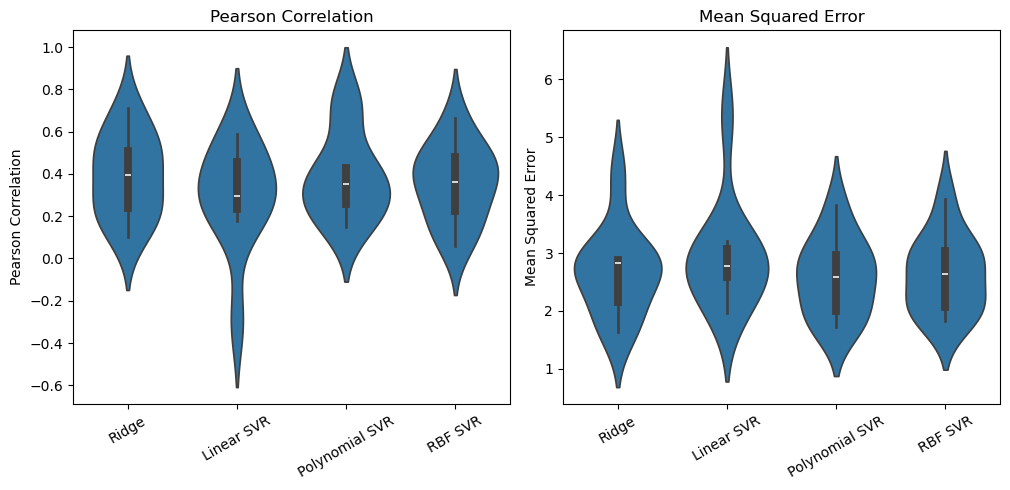

In [15]:
ncols = 2
fig, ax = plt.subplots(ncols = ncols, figsize = (ncols*5.1, 5))

for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
    viz_df = viz_df_[[col for col in viz_df_ if 'random' not in col]]
    viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type] for model_type in best_pipelines.keys()})

    # may want to do this across all comparisons simultaneously
    res_stats, mod_combs = get_stats(viz_df, stat_type = 'within', 
                                     model_type = None, 
                                     metric_type = None)

    sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i])
    ax[i].set_title(metric_type)
    ax[i].set_xlabel('')

    xlabels = [x._text for x in ax[i].get_xticklabels()]
    ax[i].set_xticklabels(xlabels, 
                      rotation=30, 
                     ha = 'center')

    x_pos = dict(zip(xlabels, ax[i].get_xticks()))

    y_lower, y = ax[i].get_ylim()
    h = unit_map['h'][metric_type]

    # significance
    sig_counter = 0
    for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"

        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                    [y_pos, y_pos+h, y_pos+h, y_pos], 
                    lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric_type]
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        ax[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
fig.tight_layout()

plt.savefig(os.path.join(data_path, 'figures', 'consensus_proteomics.png'), 
            dpi=300, 
            bbox_inches="tight")  


There is no significant difference in consensus model performance by either metric.

### Assessment 3

Finally, let's test whether there is a difference in these model performances vs the consensus model identified in transcriptomics. We use the consensus linear SVR as outlined in [this notebook](../A_rna_prediction/03_predict_transcriptomics.ipynb). 

We use the results from the power analysis [here](../A_rna_prediction/05_power_analysis_transcriptomics.ipynb), selecting the run with the number of samples equal to the number of samples available to proteomics. One caveat here is that the transcriptomic results were note calculated on the same set of folds as proteomics. However, given the bootstrapping of 100 subsets per fold, results should be consistent. 

In [36]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_protein.csv'), index_col = 0)['mean'].values.ravel()


transcriptomics_power = pd.read_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics_linear_svr.csv'), index_col = 0)
transcriptomics_res = transcriptomics_power[transcriptomics_power.train_sample_size == y.shape[0]]


In [37]:
transcriptomics_res.test_mse.mean()

np.float64(2.209231820916956)

In [38]:
transcriptomics_res.test_mse.std()

np.float64(0.41400256765967636)

In [39]:
transcriptomics_res.test_corr.mean()

np.float64(0.43747746008402144)

In [40]:
transcriptomics_res.test_corr.std()

np.float64(0.08776967780115495)

metric: Mean Squared Error, comparison: Linear SVR - Transcriptomics^Polynomial SVR, cohend:-0.9095, fdr:0.0627


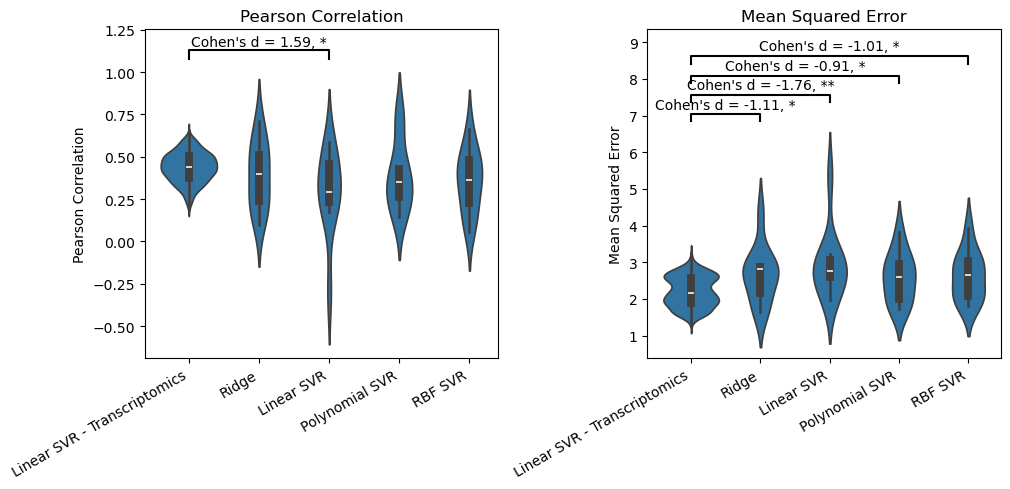

In [41]:
ncols = 2
fig, ax = plt.subplots(ncols = ncols, figsize = (ncols*5.1, 5))

res_stats_all = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d', 'fdr'])

for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
    viz_df = viz_df_[[col for col in viz_df_ if 'random' not in col]]
    viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type] for model_type in best_pipelines.keys()})

    viz_df_rna = pd.DataFrame(data = {'Model Type': 'Linear SVR - Transcriptomics', 
                                      metric_type: transcriptomics_res['test_' + mmap[metric_type]]}
                             ).reset_index(drop = True)
    viz_df = pd.concat([viz_df_rna, viz_df], axis = 0)
    
    res_stats, mod_combs = get_stats(viz_df, stat_type = 'transcriptomics', 
                                     model_type = None, 
                                     metric_type = None)
    res_stats_ = res_stats.copy()
    res_stats['metric'] = metric_type
    res_stats_all = pd.concat([res_stats_all, res_stats], axis = 0)
    
    if metric_type == 'Mean Squared Error':
        cd_print, fdr_print = res_stats[res_stats.comparison == ('Linear SVR - Transcriptomics', 'Polynomial SVR')][['cohen_d', 'fdr']].values.tolist()[0]

        print(', '.join(['metric: ' + metric_type, 
                  'comparison: Linear SVR - Transcriptomics^Polynomial SVR', 
                  'cohend:{:.4f}'.format(cd_print), 
                  'fdr:{:.4f}'.format(fdr_print)]))

    sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i])
    ax[i].set_title(metric_type)
    ax[i].set_xlabel('')

    xlabels = [x._text for x in ax[i].get_xticklabels()]
    ax[i].set_xticklabels(xlabels, 
                      rotation=30, 
                     ha = 'right')

    x_pos = dict(zip(xlabels, ax[i].get_xticks()))

    y_lower, y = ax[i].get_ylim()
    h = unit_map['h'][metric_type]

    # significance
    sig_counter = 0
    for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"

        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                    [y_pos, y_pos+h, y_pos+h, y_pos], 
                    lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric_type]
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        ax[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'consensus_proteomics_comparison.png'), 
            dpi=300, 
            bbox_inches="tight")  

res_stats_all.to_csv(os.path.join(data_path, 'interim', 'proteomics_consensus_comparison_statistics.csv'))

Overall, there is no difference in predictive performance as measured by Pearson correlation between the consensus transcriptomics model and the various consensus proteomics models, with the exception of the proteomic linear SVR, which performs worse. This is particularly interesting for the polynomial and RBF SVR, which only require 1000 features for the proteomics, in contrast to all features in the transcriptomics model. However, since these use non-linear kernels, they are less easily interpretable. 

Furthermore, all proteomics models perform worse by MSE than the consensus linear model. Taken together with the fact that only the linear SVR proteomic model performed better than both random baselines, these results indicate that prediction on transcriptomics alone may have higher utility than on proteomics alone. 

The consensus model for transcriptomics outperforms all three consensus models for proteomics as measured by MSE, and two of three consensus models for proteomics as measured by Pearson correlation. Overall, this indicates that the transcriptomics dataset 

In [42]:
fns = [os.path.join(data_path, 'figures', 'consensus_proteomics_comparison.png'), 
       os.path.join(data_path, 'figures', 'random_proteomics.png'), 
       os.path.join(data_path, 'processed', 'proteomics_consensus_performance.csv'), 
       os.path.join(data_path, 'figures', 'all_models_proteomics.png')]

for fn in fns:
    cmd = 'scp hmbaghda@satori-login-002.mit.edu:' + fn
    cmd += ' Downloads/figures/.'
    print(cmd)

scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/figures/consensus_proteomics_comparison.png Downloads/figures/.
scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/figures/random_proteomics.png Downloads/figures/.
scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/processed/proteomics_consensus_performance.csv Downloads/figures/.
scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/figures/all_models_proteomics.png Downloads/figures/.
